# Description du Notebook

Ce notebook permet d'entraîner un modèle de NER en français avec spaC en se basant les infos de voyage. 

Les étapes incluent : 
- l'importation, le nettoyage et la préparation des données annotées,
- l'entraînement du modèle. 

Ensuite, on fait un comparaison de performances entre le modèle personnalisé et le modèle spaCy préentraîné, avec des visualisations pour évaluer la diversité et le nombre d'entités détectées par chaque modèle.


In [ ]:
import spacy
from spacy.training import Example
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from spacy.util import minibatch, compounding
from spacy.scorer import Scorer
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import ast
import seaborn as sns
from tqdm import tqdm

print("imported")

imported


In [13]:
dataset_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/raw/generated_dataset/token.csv"
model_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/spacy/"

print("Paths defined")

Paths defined


In [ ]:
def load_model_with_progress(model_name):
    with tqdm(total=100, desc="Loading spaCy model") as pbar:
        nlp = spacy.load(model_name)
        pbar.update(100)
    return nlp

# Charger le modèle spaCy avec une barre de progression
nlp = load_model_with_progress("fr_core_news_lg")
print("spacy model loaded")

Loading spaCy model: 100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


spacy model loaded


In [15]:
print("Retrieving the NER pipeline...")
ner = nlp.get_pipe("ner")
print("Retrieve successfull\n")

print("Adding labels...")
ner.add_label("ARR")
ner.add_label("DEP")
print("Added labels")

Retrieving the NER pipeline...
Retrieve successfull

Adding labels...
Added labels


In [16]:
def load_dataset_with_progress(dataset_path):
    with tqdm(total=100, desc="Loading dataset") as pbar:
        dataset = pd.read_csv(dataset_path, delimiter=';', quotechar='"', names=["text", "tokens", "ner_tags", "spacy_ner_tags"])
        pbar.update(100)
    return dataset

dataset = load_dataset_with_progress(dataset_path)
print("Dataset loaded successfully")

Loading dataset: 100%|██████████| 100/100 [00:01<00:00, 84.34it/s]

Dataset loaded successfully


In [17]:
# Checking entity alignment
def is_entity_well_aligned(text, start, end):
    if start > 0 and text[start - 1].isalnum():
        return False
    if end < len(text) and text[end].isalnum():
        return False
    return True

# Evaluating with ast.literal_eval
def safe_eval(val):
    try:
        # Normalize quotation marks to help with literal evaluation
        val = val.replace('""', "'").replace("'", '"')
        return ast.literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return None
    
print("Preparing training datas...")
CONVERTED_TRAIN_DATA = []
misaligned_examples_count = 0
print("Prepared training dataset...")

Preparing training datas...
Prepared training dataset...


In [18]:
for _, item in dataset.iterrows():
    tokens_str = item['tokens'].replace("'", '"')
    spacy_ner_tags_str = item['spacy_ner_tags'].replace("'", '"') if pd.notnull(item['spacy_ner_tags']) else None

    tokens = safe_eval(tokens_str)
    if tokens is None:
        continue

    if spacy_ner_tags_str:
        annotations = safe_eval(spacy_ner_tags_str)

        if annotations is not None:
            entities = []
            for annotation in annotations:
                start, end = annotation['start'], annotation['end']
                if is_entity_well_aligned(" ".join(tokens), start, end):
                    entities.append((start, end, annotation['label']))
            CONVERTED_TRAIN_DATA.append((" ".join(tokens), {"entities": entities}))
        else:
            misaligned_examples_count += 1
            CONVERTED_TRAIN_DATA.append((" ".join(tokens), {"entities": []}))
    else:
        misaligned_examples_count += 1
        CONVERTED_TRAIN_DATA.append((" ".join(tokens), {"entities": []}))

print(f"Number of misaligned examples ignored: {misaligned_examples_count}")

Number of misaligned examples ignored: 9010


In [19]:
examples = []
for text, annots in CONVERTED_TRAIN_DATA:
    try:
        doc = nlp.make_doc(text)
        examples.append(Example.from_dict(doc, annots))
    except ValueError:
        continue

C:\Users\vikne\anaconda3\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Recherche le trajet le plus court vers CHÂTEAUROUX..." with entities "[(39, 61, 'ARR'), (74, 95, 'DEP')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\vikne\anaconda3\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Recherche le trajet le plus court vers Sedan à par..." with entities "[(39, 44, 'ARR'), (57, 71, 'DEP')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\vikne\anaconda3\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Trouve- 

In [21]:
# Split datas in train, test and validation
with tqdm(total=len(examples), desc="Splitting train/test") as pbar:
    train_data, test_valid_data = train_test_split(examples, test_size=0.5, random_state=42)
    pbar.update(len(examples))

with tqdm(total=len(test_valid_data), desc="Splitting test/validation") as pbar:
    test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state=42)
    pbar.update(len(test_valid_data))

print(f"Train data: {len(train_data)} examples")
print(f"Test data: {len(test_data)} examples")
print(f"Validation data: {len(valid_data)} examples")

Splitting test/validation: 100%|██████████| 41826/41826 [00:00<00:00, 2476404.33it/s]

Train data: 41825 examples
Test data: 20913 examples
Validation data: 20913 examples


In [34]:
# Fine-tuning the model and tracking performance
losses_hist, f1_hist, recall_hist, precision_hist = [], [], [], []
epochs = 20  # Nombre d'époques
with nlp.disable_pipes(*[pipe for pipe in nlp.pipe_names if pipe != "ner"]):
    optimizer = nlp.begin_training()
    
    # Boucle sur les époques avec une barre de progression
    for i in tqdm(range(epochs), desc="Entraînement du modèle (par époque)", unit="époque"):
        random.shuffle(train_data)
        losses = {}
        
        # Boucle sur les batches avec une autre barre de progression
        batches = minibatch(train_data, size=compounding(16.0, 64.0, 1.001))
        for batch in tqdm(batches, desc=f"Époque {i+1}/{epochs}", leave=False, unit="batch"):
            nlp.update(batch, drop=0.2, losses=losses, sgd=optimizer)
        
        print(f"Losses at epoch {i}: {losses}")

        # Track losses and evaluation scores over iterations
        losses_hist.append(losses['ner'])
        valid_scores = evaluate(nlp, valid_data)
        f1_hist.append(valid_scores['ents_f'])
        recall_hist.append(valid_scores['ents_r'])
        precision_hist.append(valid_scores['ents_p'])

Entraînement du modèle (par époque):   0%|          | 0/20 [00:00<?, ?époque/s]

Losses at epoch 0: {'ner': 35467.742101706724}


Entraînement du modèle (par époque):   5%|▌         | 1/20 [06:15<1:59:02, 375.91s/époque]

Losses at epoch 1: {'ner': 21529.509759540793}


Entraînement du modèle (par époque):  10%|█         | 2/20 [11:40<1:43:47, 345.98s/époque]

Losses at epoch 2: {'ner': 16576.591843410857}


Entraînement du modèle (par époque):  15%|█▌        | 3/20 [17:08<1:35:37, 337.50s/époque]

Losses at epoch 3: {'ner': 14656.421230710263}


Entraînement du modèle (par époque):  20%|██        | 4/20 [22:19<1:27:11, 326.98s/époque]

Losses at epoch 4: {'ner': 13680.7777314355}


Entraînement du modèle (par époque):  25%|██▌       | 5/20 [27:47<1:21:49, 327.31s/époque]

Losses at epoch 5: {'ner': 12873.87212009989}


Entraînement du modèle (par époque):  30%|███       | 6/20 [36:43<1:32:56, 398.32s/époque]

Losses at epoch 6: {'ner': 12211.353889152466}


Entraînement du modèle (par époque):  35%|███▌      | 7/20 [44:33<1:31:23, 421.80s/époque]

Losses at epoch 7: {'ner': 11618.383515744956}


Entraînement du modèle (par époque):  40%|████      | 8/20 [50:19<1:19:31, 397.60s/époque]

Losses at epoch 8: {'ner': 11095.929625694684}


Entraînement du modèle (par époque):  45%|████▌     | 9/20 [58:27<1:18:06, 426.08s/époque]

Losses at epoch 9: {'ner': 10851.91678294867}


Entraînement du modèle (par époque):  50%|█████     | 10/20 [1:06:47<1:14:46, 448.63s/époque]

Losses at epoch 10: {'ner': 10592.730298974782}


Entraînement du modèle (par époque):  55%|█████▌    | 11/20 [1:14:02<1:06:40, 444.50s/époque]

Losses at epoch 11: {'ner': 10390.117850355358}


Entraînement du modèle (par époque):  60%|██████    | 12/20 [1:21:44<59:59, 449.94s/époque]  

Losses at epoch 12: {'ner': 10151.98495905559}


Entraînement du modèle (par époque):  65%|██████▌   | 13/20 [1:29:43<53:30, 458.61s/époque]

Losses at epoch 13: {'ner': 9851.908676819741}


Entraînement du modèle (par époque):  70%|███████   | 14/20 [1:37:29<46:06, 461.04s/époque]

Losses at epoch 14: {'ner': 9807.937859460028}


Entraînement du modèle (par époque):  75%|███████▌  | 15/20 [1:45:28<38:52, 466.42s/époque]

Losses at epoch 15: {'ner': 9628.182440684168}


Entraînement du modèle (par époque):  80%|████████  | 16/20 [1:54:09<32:10, 482.75s/époque]

Losses at epoch 16: {'ner': 9605.108753884773}


Entraînement du modèle (par époque):  85%|████████▌ | 17/20 [2:02:22<24:17, 485.78s/époque]

Losses at epoch 17: {'ner': 9368.236129376593}


Entraînement du modèle (par époque):  90%|█████████ | 18/20 [2:09:04<15:21, 460.85s/époque]

Losses at epoch 18: {'ner': 9326.476499840506}


Entraînement du modèle (par époque):  95%|█████████▌| 19/20 [2:16:05<07:28, 448.84s/époque]

Losses at epoch 19: {'ner': 9186.23945731883}


Entraînement du modèle (par époque): 100%|██████████| 20/20 [2:24:02<00:00, 432.12s/époque]


In [36]:
# Evaluation function
def evaluate(nlp, examples):
    scorer = Scorer()
    examples_to_score = []
    for example in examples:
        pred_doc = nlp(example.text)
        scored_example = Example(pred_doc, example.reference)
        examples_to_score.append(scored_example)
    scores = scorer.score(examples_to_score)
    return scores

# Evaluate on validation data
valid_scores = evaluate(nlp, valid_data)
print(f"Validation F1 Score: {valid_scores['ents_f']}, Precision: {valid_scores['ents_p']}, Recall: {valid_scores['ents_r']}")

Validation F1 Score: 0.8533009315512353, Precision: 0.830888152705474, Recall: 0.876956376956377


In [39]:
output_dir = Path("C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/spacy")
output_dir.mkdir(parents=True, exist_ok=True)
nlp.to_disk(output_dir)

In [40]:
# Test data evaluation
test_scores = evaluate(nlp, test_data)
print(f"Test F1 Score: {test_scores['ents_f']}, Test Precision: {test_scores['ents_p']}, Test Recall: {test_scores['ents_r']}")

Test F1 Score: 0.8577965599849264, Test Precision: 0.8368257969644451, Test Recall: 0.8798453892876864


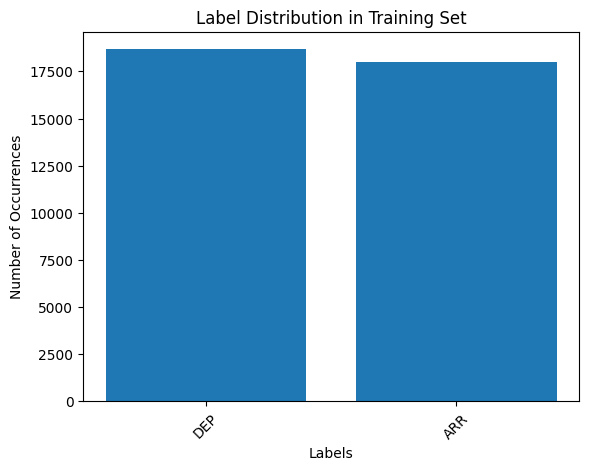

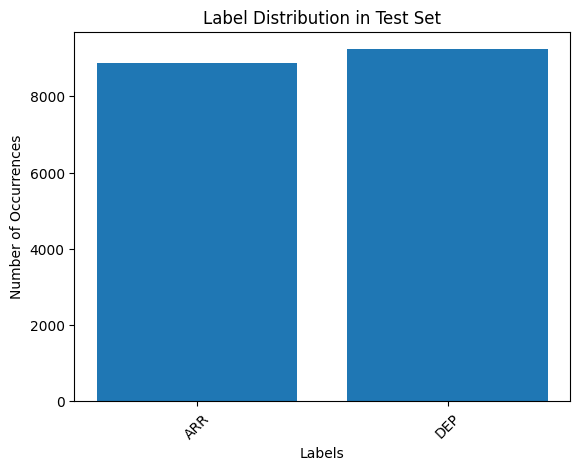

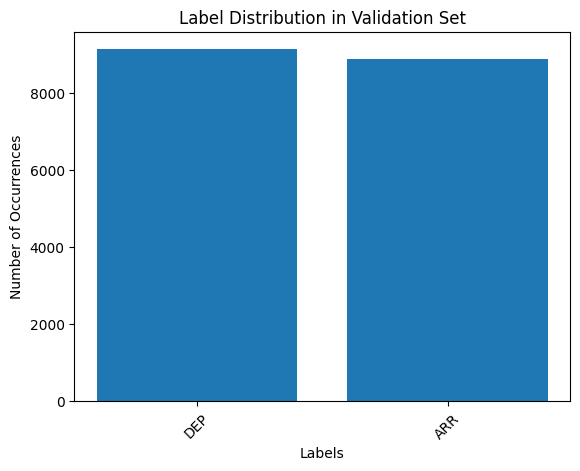

In [41]:
# Plot label distribution
def plot_label_distribution(examples, label="Training"):
    label_counts = Counter([ent.label_ for example in examples for ent in example.reference.ents])
    labels, counts = zip(*label_counts.items())
    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Number of Occurrences')
    plt.title(f'Label Distribution in {label} Set')
    plt.xticks(rotation=45)
    plt.show()

# Visualize label distribution
plot_label_distribution(train_data, "Training")
plot_label_distribution(test_data, "Test")
plot_label_distribution(valid_data, "Validation")

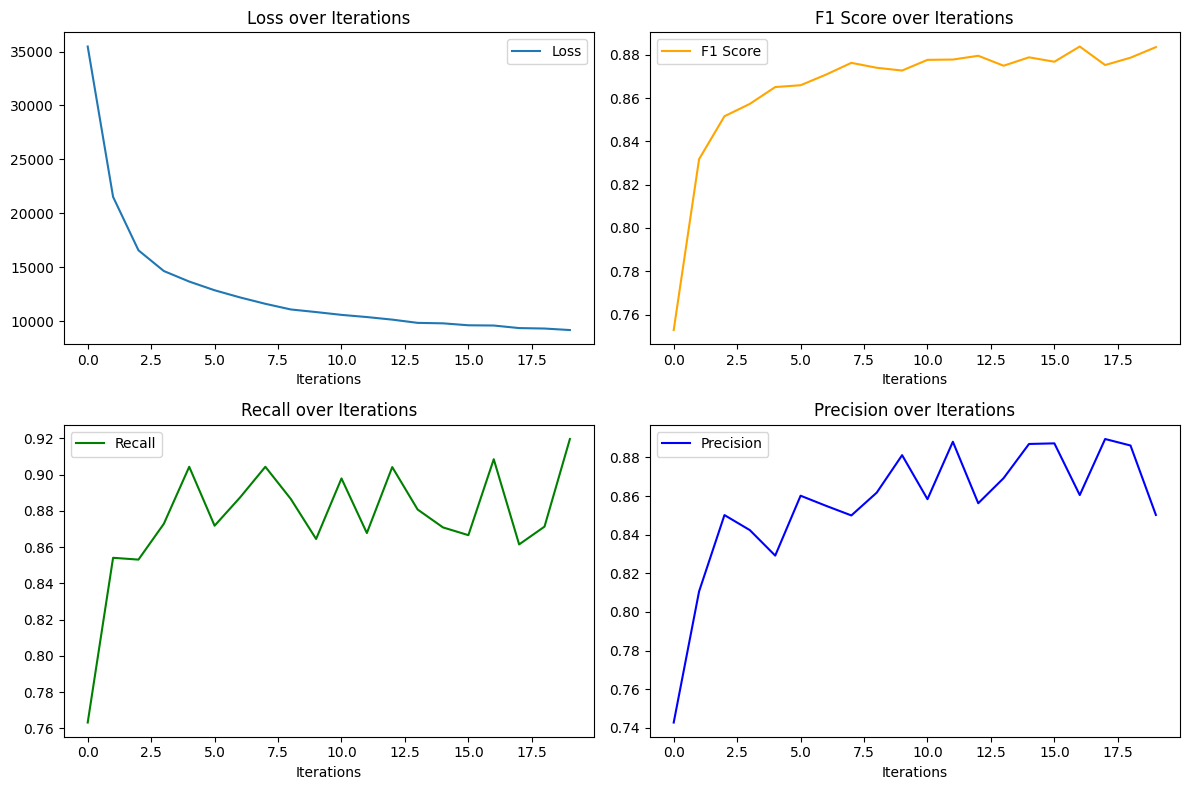

In [42]:
# Performance Curves
def draw_scores(losses_hist, f1_hist, recall_hist, precision_hist):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs[0, 0].plot(losses_hist, label="Loss")
    axs[0, 0].set_title("Loss over Iterations")
    axs[0, 1].plot(f1_hist, label="F1 Score", color="orange")
    axs[0, 1].set_title("F1 Score over Iterations")
    axs[1, 0].plot(recall_hist, label="Recall", color="green")
    axs[1, 0].set_title("Recall over Iterations")
    axs[1, 1].plot(precision_hist, label="Precision", color="blue")
    axs[1, 1].set_title("Precision over Iterations")
    for ax in axs.flat:
        ax.legend()
        ax.set_xlabel("Iterations")
    plt.tight_layout()
    plt.show()

# Plot performance curves
draw_scores(losses_hist, f1_hist, recall_hist, precision_hist)

C:\Users\vikne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\vikne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\vikne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\vikne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

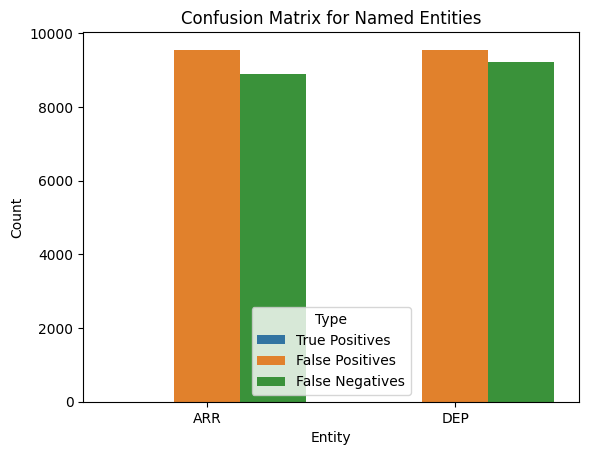

In [43]:
# Confusion Matrix for Named Entities
def plot_confusion_matrix(true_pos, false_pos, false_neg):
    # Get all unique entity labels across true_pos, false_pos, and false_neg
    all_labels = set(true_pos.keys()).union(false_pos.keys(), false_neg.keys())
    
    # Initialize the counts for all labels to ensure all are represented
    true_pos = {label: true_pos.get(label, 0) for label in all_labels}
    false_pos = {label: false_pos.get(label, 0) for label in all_labels}
    false_neg = {label: false_neg.get(label, 0) for label in all_labels}
    
    # Prepare data for plotting
    data = {
        "Entity": list(all_labels) * 3,
        "Type": ["True Positives"] * len(all_labels) + ["False Positives"] * len(all_labels) + ["False Negatives"] * len(all_labels),
        "Count": [true_pos[label] for label in all_labels] + [false_pos[label] for label in all_labels] + [false_neg[label] for label in all_labels]
    }
    
    # Create a DataFrame for visualization
    df = pd.DataFrame(data)
    
    # Plotting the confusion matrix
    sns.barplot(x="Entity", y="Count", hue="Type", data=df)
    plt.title("Confusion Matrix for Named Entities")
    plt.show()

# Re-calculate confusion matrix details with initialized counts
true_pos = Counter([ent.label_ for example in test_data for ent in example.reference.ents if ent in nlp(example.text).ents])
false_pos = Counter([ent.label_ for example in test_data for ent in nlp(example.text).ents if ent not in example.reference.ents])
false_neg = Counter([ent.label_ for example in test_data for ent in example.reference.ents if ent not in nlp(example.text).ents])

# Plot the confusion matrix
plot_confusion_matrix(true_pos, false_pos, false_neg)

In [44]:
def test_ner_model(nlp, sentences):
    """
    Fonction pour tester le modèle NER sur des phrases données
    :param nlp: le modèle spaCy NER entraîné
    :param sentences: liste de phrases à tester
    """
    for sentence in sentences:
        doc = nlp(sentence)
        print(f"\nPhrase : {sentence}")
        print("Entités reconnues :")
        for ent in doc.ents:
            print(f" - Texte : {ent.text}, Label : {ent.label_}, Position : ({ent.start_char}, {ent.end_char})")

# Exemples de phrases à tester
test_sentences = [
    "Je pars de Paris et j'arrive à Marseille.",
    "Je vais à Bordeaux en partant de Toulouse",
    "Mon trajet va de VILLIERS SUR LOIR à JARNY"
]

# Appel de la fonction pour tester le modèle
test_ner_model(nlp, test_sentences)


Phrase : Je pars de Paris et j'arrive à Marseille.
Entités reconnues :
 - Texte : Paris, Label : DEP, Position : (11, 16)

Phrase : Je vais à Bordeaux en partant de Toulouse
Entités reconnues :
 - Texte : Bordeaux, Label : ARR, Position : (10, 18)

Phrase : Mon trajet va de VILLIERS SUR LOIR à JARNY
Entités reconnues :
 - Texte : VILLIERS SUR LOIR, Label : DEP, Position : (17, 34)
 - Texte : JARNY, Label : ARR, Position : (37, 42)
